In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import inspect

## CIFAR 10 dataset

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding = "bytes")
    return data

In [3]:
cifar_batch = unpickle("cifar10/cifar-10-batches-py/data_batch_1")
label_names = unpickle("cifar10/cifar-10-batches-py/batches.meta")[b'label_names']
label_names

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [4]:
def roll_cifar_single(flat_image):
    """
    flat_image -- of shape (3072, ), first red channel pixels, then green, then blue.
    
    Returns:
    image -- of shape (32, 32, 3)
    """
    image = np.zeros((32, 32, 3))
    image[:, :, 0] = flat_image[0:1024].reshape((32, 32))
    image[:, :, 1] = flat_image[1024:2048].reshape((32, 32))
    image[:, :, 2] = flat_image[2048:3072].reshape((32, 32))
    return image.astype(np.uint8) # Transform to integer type. Important for visualization.

In [3]:
def roll_cifar(flat_images):
    """
    Vectorized impl that rolls array of images.
    
    flat_images -- of shape (m, 3072, ), m images, first red channel pixels, then green, then blue.
    
    Returns:
    images -- of shape (m, 32, 32, 3)
    """
    (m, _) = flat_images.shape
    images = np.zeros((m, 32, 32, 3))
    images[:, :, :, 0] = flat_images[:, 0:1024].reshape((-1, 32, 32))
    images[:, :, :, 1] = flat_images[:, 1024:2048].reshape((-1, 32, 32))
    images[:, :, :, 2] = flat_images[:, 2048:3072].reshape((-1, 32, 32))
    return images.astype(np.uint8) # Transform to integer type. Important for visualization.

In [6]:
idx = 34
images = roll_cifar(cifar_batch[b'data'][idx:(idx + 2)])
label = cifar_batch[b'labels'][idx:(idx + 2)]
print(label_names[label[0]], label_names[label[1]])

b'deer' b'airplane'


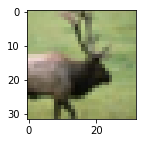

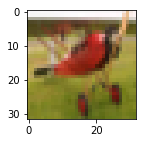

In [7]:
plt.figure(figsize=(2, 2))
plt.imshow(images[0])
plt.figure(figsize=(2, 2))
plt.imshow(images[1])
plt.show()

## Train and test data

In [4]:
train_batch1 = unpickle("cifar10/cifar-10-batches-py/data_batch_1")
test_batch = unpickle("cifar10/cifar-10-batches-py/test_batch")
X_train = roll_cifar(train_batch1[b'data']) / 255.
X_test = roll_cifar(test_batch[b'data']) / 255.
binarizer = LabelBinarizer().fit(train_batch1[b'labels'])
Y_train = binarizer.transform(train_batch1[b'labels'])
Y_test = binarizer.transform(test_batch[b'labels'])

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("Y_train: ", Y_train.shape)
print("Y_test: ", Y_test.shape)

X_train:  (10000, 32, 32, 3)
X_test:  (10000, 32, 32, 3)
Y_train:  (10000, 10)
Y_test:  (10000, 10)


## Input data placeholder

In [5]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    xs = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    ys = tf.placeholder(tf.float32, [None, n_y])
    return xs, ys

## Initialize parameters

Initialize weights (filters) using `tf.contrib.layers.xavier_initializer`.
We only need to initialize for the `conv2d` functions. TensorFlow initializers the fully connected layers automatically.

More about `xavier initializer`: To help reduce the vanishing/exploding gradient problem. Recall that we compute this:
$$z = W_1X_1 + \cdots + W_nX_n$$
before applying activation $a = g(z)$. In order to NOT have a too big (too small) $z$ (to avoid the long tail of activation function), we would prefer "smaller $W_i$ for larger $n$". Assuming input $X_i$s have roughly mean 0 and unit variance, then one approach to initialize $W_i$s is to make
$$Var(W_i) = \frac{1}{n}$$
So we can initalize like

`W = np.random.randn(shape) * np.sqrt(1./n)`

(Note `randn` draws sample from standard normal distribution.)

In [6]:
def initialize_parameters():
    """
    We use two conv layers. Initialize two filters:
    W1: [4, 4, 3, 8]
    W2: [2, 2, 8, 16]
    
    Returns:
    parameters -- a dictionary containing W1, W2
    """
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1", [4, 4, 3, 8], \
                         initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], \
                         initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    parameters = {"W1": W1, "W2": W2}
    return parameters

In [11]:
tf.reset_default_graph()
with tf.Session() as session:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    session.run(init)
    print("W1 = ", parameters["W1"].eval()[1, 1, 1])
    print("W2 = ", parameters["W2"].eval()[1, 1 ,1])

W1 =  [ 0.00131723  0.14176141 -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 =  [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


## Forward propagation

In TensorFlow, there are built-in functions that carry out the convolution steps for you.

- **tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'):** given an input $X$ and a group of filters $W1$, this function convolves $W1$'s filters on X. The third input ([1,f,f,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)

- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window. You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)

- **tf.nn.relu(Z1):** computes the elementwise ReLU of Z1 (which can be any shape). You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/nn/relu)

- **tf.contrib.layers.flatten(P)**: given an input P, this function flattens each example into a 1D vector it while maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k]. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)

- **tf.contrib.layers.fully_connected(F, num_outputs):** given a the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected)
**Question: But how do you extract the weights?** This link helps [here](https://stackoverflow.com/questions/43158606/how-to-get-weights-from-tensorflow-fully-connected)

In the last function above (`tf.contrib.layers.fully_connected`), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize those weights when initializing the parameters. 

**NOTE**: Many of the above functions have multiple equivalent versions in TensorFlow. For example, `tf.nn.conv2d` and `tf.layers.conv2d`; `tf.contrib.layers.fully_connected` and `tf.layers.dense`, etc. BUT, some of their arguments might be different.

**Exercise**: 

Implement the `forward_propagation` function below to build the following model: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED`. You should use the functions above. 

In detail, we will use the following parameters for all the steps:
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
     - Flatten the previous output.
     - FULLYCONNECTED (FC) layer: Apply a fully connected layer without an non-linear activation function. Do not call the softmax here. This will result in 6 neurons in the output layer, which then get passed later to a softmax. In TensorFlow, the softmax and cost function are lumped together into a single function, which you'll call in a different function when computing the cost. 
     
NOTE: **The padding scheme for conv2d and max_pool is not as simple as described in Andrew's video. We should check the following TensorFlow's documentation** [here](https://www.tensorflow.org/api_guides/python/nn#convolution)

In [7]:
def forward_propagation(X, Y, parameters):
    """
    Implements the forward propagation for the model:
    conv2d -> relu -> maxpool -> conv2d -> relu -> maxpool -> flatten -> fullyconnected
    
    X -- input dataset placeholder, of shape (m, n_H, n_W, n_C)
    Y -- of shape (m, #classes), used for determining the #classes
    parameters -- two filters "W1" and "W2"
    
    Returns:
    Z3 -- output of the last LINEAR unit
    """
    (W1, W2) = (parameters["W1"], parameters["W2"])
    num_of_classes = Y.shape[1].value
    
    Z1 = tf.nn.conv2d(X, W1, strides = [1, 1, 1, 1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding = 'SAME')
    Z2 = tf.nn.conv2d(P1, W2, strides = [1, 1, 1, 1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding = 'SAME')
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, num_of_classes, activation_fn=None)
    
    return Z3
    

In [13]:
tf.reset_default_graph()
with tf.Session() as session:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, Y, parameters)
    init = tf.global_variables_initializer()
    session.run(init)
    a = session.run(Z3, feed_dict = {X: np.random.randn(2, 64, 64, 3), Y: np.random.randn(2, 6)})
    print("Z3 = ", a)

Z3 =  [[-0.44670227 -1.57208765 -1.53049231 -2.31013036 -1.29104376  0.46852064]
 [-0.17601591 -1.57972014 -1.4737016  -2.61672091 -1.00810647  0.5747785 ]]


## Compute cost

Implement the compute cost function below. You might find these two functions helpful: 

- **tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y):** computes the softmax entropy loss. This function both computes the softmax activation function as well as the resulting loss. You can check the full documentation  [here.](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
- **tf.reduce_mean:** computes the mean of elements across dimensions of a tensor. Use this to sum the losses over all the examples to get the overall cost. You can check the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)

** Exercise**: Compute the cost below using the function above.

In [8]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(\
        tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

In [15]:
tf.reset_default_graph()
with tf.Session() as session:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, Y, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    session.run(init)
    c = session.run(cost, feed_dict = {X: np.random.randn(4, 64, 64, 3), Y: np.random.randn(4, 6)})
    print("cost = ", c)

cost =  2.91034


## Model

### Mini-batch

In [9]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (m, n_H, n_W, n_C)
    Y -- true "label" vector, of shape (m, #classes)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = np.floor(m/mini_batch_size).astype(int) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[(k * mini_batch_size) : ((k + 1) * mini_batch_size), :]
        mini_batch_Y = shuffled_Y[(k * mini_batch_size) : ((k + 1) * mini_batch_size), :]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[(num_complete_minibatches * mini_batch_size) : m, :]
        mini_batch_Y = shuffled_Y[(num_complete_minibatches * mini_batch_size) : m, :]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### Model
The model below should:

- create placeholders
- initialize parameters
- forward propagate
- compute the cost
- create an optimizer

In [10]:
def compute_accuracy(outputs, Y):
    return np.mean(np.argmax(outputs, 1) == np.argmax(Y, 1))

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009, 
          num_epochs = 100, minibatch_size = 64):
    """
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    tf.reset_default_graph()
    tf.set_random_seed(1)  # tensorflow seed
    numpy_seed = 3  # numpy seed
    
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, Y, parameters)
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init)
        for i in range(num_epochs):
            avg_cost = 0.
            num_minibatches = m / minibatch_size
            numpy_seed = numpy_seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, numpy_seed)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                session.run(optimizer, feed_dict = {X: minibatch_X, Y: minibatch_Y})
                mini_batch_cost = session.run(cost, feed_dict = {X: minibatch_X, Y: minibatch_Y})
                
                avg_cost = mini_batch_cost / num_minibatches
                
            costs.append(avg_cost)
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(costs)
        ax.set_xlabel("iterations")
        ax.set_ylabel("cost")
        plt.show()
        
        train_accuracy = compute_accuracy(Z3.eval({X: X_train, Y: Y_train}), Y_train)
        test_accuracy = compute_accuracy(Z3.eval({X: X_test, Y:Y_test}), Y_test)
        
        # BUT: parameters only contain those in conv layers, what about fully connected layer?
        return train_accuracy, test_accuracy, parameters
        

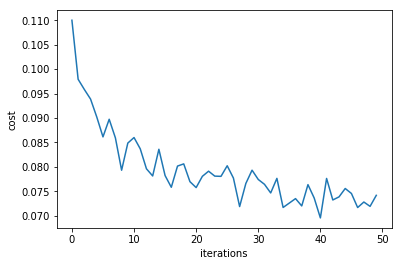

In [14]:
train_accuracy, test_accuracy, parameters = \
    model(X_train, Y_train, X_test, Y_test, num_epochs = 50, minibatch_size = 500)

In [15]:
print("train accuracy: ", train_accuracy)
print("test accuracy: ", test_accuracy)

train accuracy:  0.4862
test accuracy:  0.4442
